In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import tensorflow as tf
from transformers import BertTokenizer


In [73]:
train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('test.csv', dtype={'id': np.int16})

In [74]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [75]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


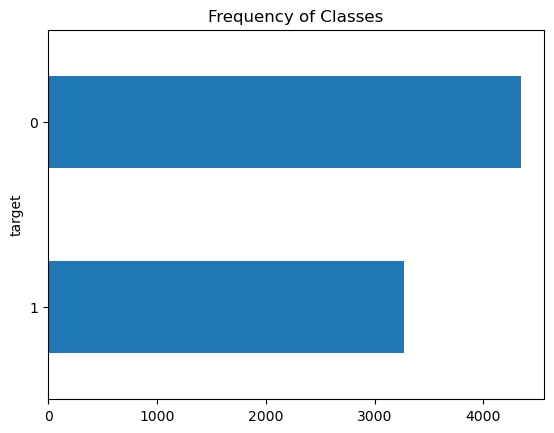

In [76]:
#0:Not Disaster, 1:Disaster
train["target"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

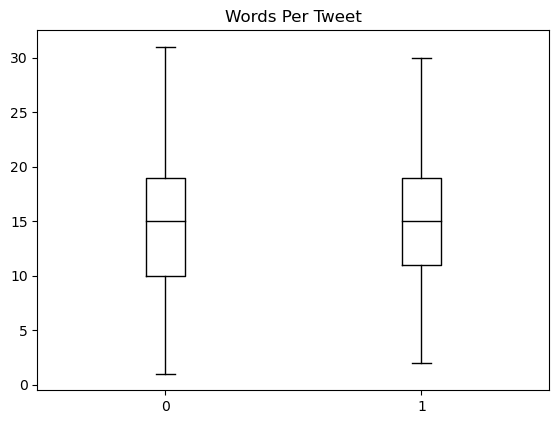

In [77]:
train["Words Per Tweet"] = train["text"].str.split().apply(len)
train.boxplot("Words Per Tweet", by="target", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [78]:
train = train.drop(['Words Per Tweet'],axis=1)
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## Training

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords

In [80]:
if torch.cuda.is_available() : device = torch.device('cuda')
elif torch.backends.mps.is_available() : device = torch.device('mps')
else : device=torch.device('cpu')
print(f'Using {device}')

Using mps


In [81]:
# 텍스트 데이터와 라벨 데이터를 읽어옴
text_data = train['text']
label_data = train['target']

In [82]:
# 정규표현식 패턴
pattern = r'\b\w+\b'  # 단어 단위로 패턴 매칭

# 불용어 목록
stopwords_list = stopwords.words('english')  # 필요한 언어로 변경

# 함수 정의
def preprocess_text(text):
    # 정규표현식을 사용하여 문장에서 단어 추출
    words = re.findall(pattern, text.lower())
    
    # 불용어 처리
    words = [word for word in words if word not in stopwords_list]
    
    # 처리된 단어들을 다시 문장으로 결합하여 반환
    return ' '.join(words)

# 'text' 열에 대해 전처리 적용
train['text'] = train['text'].apply(preprocess_text)
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [83]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train['text'])

In [84]:
# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, train['target'], test_size=0.2, random_state=42)

# 나이브 베이즈 분류 모델 학습
model = MultinomialNB()
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 분류 결과 평가
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       874
           1       0.83      0.66      0.73       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



## Prediction

In [85]:
test['text'] = test['text'].apply(preprocess_text)
test_df = test['text']
test_df.head()

0                          happened terrible car crash
1    heard earthquake different cities stay safe ev...
2    forest fire spot pond geese fleeing across str...
3                apocalypse lighting spokane wildfires
4               typhoon soudelor kills 28 china taiwan
Name: text, dtype: object

In [86]:
# TF-IDF 벡터화
new_X = vectorizer.transform(test_df)

In [87]:
predictions = model.predict(new_X)
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [88]:
submission = pd.read_csv('sample_submission_.csv')
submission['target']=predictions
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [90]:
# 예측 결과를 CSV 파일에 저장
submission.to_csv('submission_stopwords_MultinomialNB.csv', index=False)